In [1]:
# %load_ext autoreload
# %autoreload 2

import syft as sy
from utils import *
from syft import NewDataSubject

/home/shubham/anaconda3/envs/syft/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BreastCancerDataset-02ec48b840824b1ea3e1f5d11c45314b.pkl is already downloaded
Columns: Index(['patient_ids', 'labels', 'images'], dtype='object')
Total Images: 2775
Label Mapping {'Non-Invasive Ductal Carcinoma (IDC)': 0, 'Invasive Ductal Carcinoma (IDC)': 1}


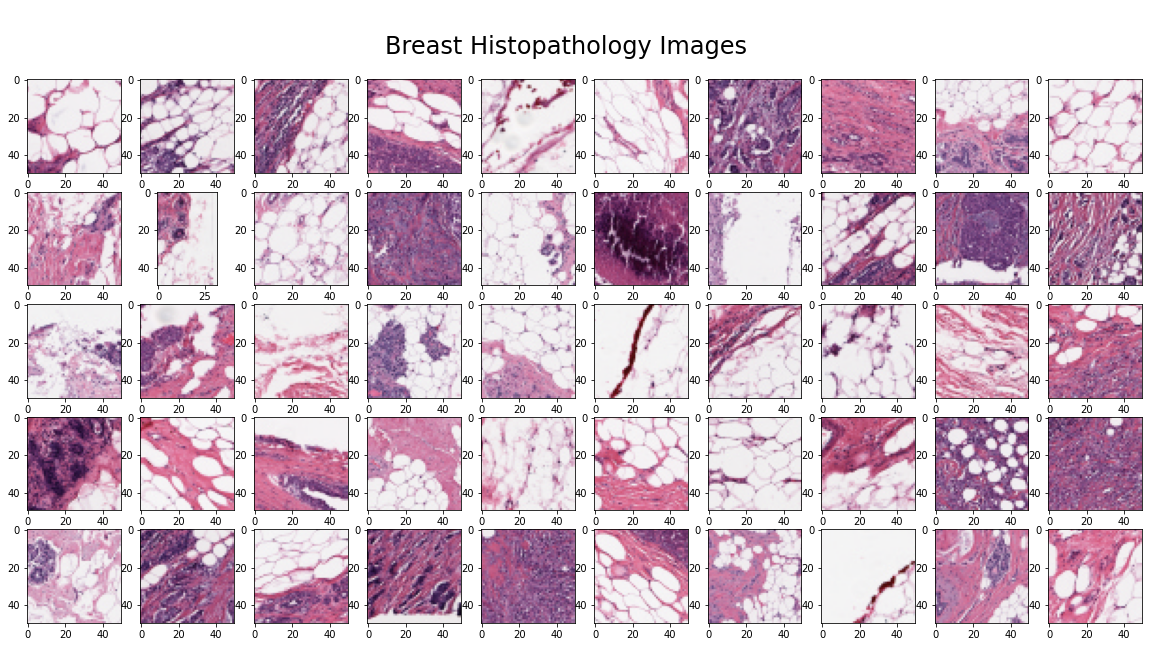

In [2]:
MY_DATASET_URL = "https://raw.githubusercontent.com/OpenMined/datasets/main/BreastCancerDataset/subsets/BreastCancerDataset-02ec48b840824b1ea3e1f5d11c45314b.pkl"
dataset = download_dataset(MY_DATASET_URL)

In [3]:
dataset.head()

,patient_ids,labels,images
0,22545,0,"[[[223, 204, 216], [238, 234, 238], [234, 228,..."
1,22545,0,"[[[205, 100, 129], [197, 86, 122], [188, 80, 1..."
2,22545,0,"[[[227, 205, 215], [204, 143, 176], [218, 169,..."
3,22545,0,"[[[239, 227, 230], [234, 197, 214], [240, 229,..."
4,22545,0,"[[[234, 221, 227], [234, 218, 227], [240, 238,..."


In [4]:
# run this cell
train, val, test = split_and_preprocess_dataset(data=dataset)

Splitting dataset into train, validation and test sets.
Preprocessing the dataset...
Dims (2235, 3, 50, 50)
Dims (279, 3, 50, 50)
Dims (261, 3, 50, 50)
Preprocessing completed.


In [5]:
# run this cell
data_subjects_image = np.ones(train["images"].shape).astype(object)
for i,patient in enumerate(train["patient_ids"]):
    data_subjects_image[i] = NewDataSubject([str(patient)])

data_subjects_labels = np.ones(train["labels"].shape).astype(object)
for i,patient in enumerate(train["patient_ids"]):
    data_subjects_labels[i] = NewDataSubject([str(patient)])

    
train_image_data = sy.Tensor(train["images"]).annotated_with_dp_metadata(
    min_val=0, max_val=255, data_subjects=data_subjects_image
)
train_label_data = sy.Tensor(train["labels"]).annotated_with_dp_metadata(
    min_val=0, max_val=1, data_subjects=data_subjects_labels
)

Tensor annotated with DP Metadata
Tensor annotated with DP Metadata


In [6]:
# from syft import PhiTensor
# def correct_dsl(input_tensor: PhiTensor):
#     """ Corrects for the new DSL shape requirements 
#     e.g. (1915,) -> (1915, 3, 50, 50) 
#     """
#     output_dsi = np.ones((input_tensor.shape[0], *input_tensor.shape[1:]))
#     print(output_dsi.shape)
    
#     for index, val in enumerate(input_tensor.data_subjects.data_subjects_indexed[0]):
#         output_dsi[index] *= val
    
#     input_tensor.data_subjects.data_subjects_indexed = output_dsi
#     # print(output_dsi.shape)
#     # print(output_dsi[0])
#     # output_dsi = np.ones(input_tensor.shape)  # b/c PhiTensor
#     # for i in range(input_tensor.shape[0]):
#     #      output_dsi[i] *= input_tensor.data_subjects.data_subjects_indexed[i]
#     # input_tensor.data_subjects.data_subjects_indexed = output_dsi

# correct_dsl(train_image_data.child)  
# # .shape, train_image_data.child.data_subjects.shape

In [7]:
# data_subjects = DataSubjectList.from_series(val["patient_ids"])
# val_image_data = sy.Tensor(val["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# val_label_data = sy.Tensor(val["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

In [8]:
# data_subjects = DataSubjectList.from_series(test["patient_ids"])
# test_image_data = sy.Tensor(test["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# test_label_data = sy.Tensor(test["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

### Model Training

In [9]:
from syft import nn

In [10]:
input_shape = train_image_data.public_shape
input_shape

(2235, 3, 50, 50)

In [11]:
y_train = train_label_data

In [12]:
input_shape = train_image_data[:2].child.shape

In [13]:
model = nn.Model()

# Layer 1
model.add(nn.Convolution(nb_filter=32, filter_size=3, padding=2, input_shape=input_shape))  # May need to change input_shape to reflect we are passing in 2 images and not 2000+
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 2
model.add(nn.Convolution(nb_filter=64, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 3
model.add(nn.Convolution(nb_filter=128, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 4
model.add(nn.Convolution(nb_filter=256, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 5
# model.add(nn.Convolution(nb_filter=512, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 6
model.add(nn.AvgPool(5))

# # Layer 7
model.add(nn.Flatten())

# # Layer 8
model.add(nn.Linear(2))

In [14]:
model.compile()

In [15]:
# for layer in model.layers[::-1]:
#     print(f"Layer: {layer}")
#     print(f"InputShape: {layer.input_shape}, OutputShape: {layer.out_shape}")

In [16]:
import time

out = train_image_data[:2].child
total_time = 0.0
for layer in model.layers:
    start  = time.time()
    print("Layer Name: ", layer)
    out = layer.forward(out)
    end = time.time()
    print(f"Time for Layer: {layer}" , end-start)
    total_time += (end-start)
    print()

Layer Name:  Convolution
out_shape (2, 32, 52, 52)
X_col_shape (27, 5408) (27, 5408)
input_shape (2, 3, 50, 50) (2, 3, 50, 50)
W_col (32, 27)
out (5408, 32)
output:  (2, 32, 52, 52) (2, 32, 52, 52)
Time for Layer: Convolution 3.32966947555542

Layer Name:  BatchNorm


Time for Layer: BatchNorm 3.542543649673462

Layer Name:  MaxPool
Output shape will be: (2, 32, 26, 26)
Time for Layer: MaxPool 0.06766319274902344

Layer Name:  Convolution
out_shape (2, 64, 28, 28)
X_col_shape (288, 1568) (288, 1568)
input_shape (2, 32, 26, 26) (2, 32, 26, 26)
W_col (64, 288)
out (1568, 64)
output:  (2, 64, 28, 28) (2, 64, 28, 28)
Time for Layer: Convolution 17.102301120758057

Layer Name:  BatchNorm
Time for Layer: BatchNorm 1.8597500324249268

Layer Name:  MaxPool
Output shape will be: (2, 64, 14, 14)
Time for Layer: MaxPool 0.0482935905456543

Layer Name:  Convolution
out_shape (2, 128, 16, 16)
X_col_shape (576, 512) (576, 512)
input_shape (2, 64, 14, 14) (2, 64, 14, 14)
W_col (128, 576)
out (512, 128)
output:  (2, 128, 16, 16) (2, 128, 16, 16)
Time for Layer: Convolution 24.197333335876465

Layer Name:  BatchNorm
Time for Layer: BatchNorm 1.3178973197937012

Layer Name:  MaxPool
Output shape will be: (2, 128, 8, 8)
Time for Layer: MaxPool 0.02931666374206543

Lay

In [17]:
# Total time to execute forward pass
total_time

90.42155361175537

## Backwards

In [18]:
y_true = train_label_data[:2].child

In [19]:
y_true.child, out.child

(array([0, 0]),
 DeviceArray([[ 0.86657592, -1.25183705],
              [ 0.96749663, -1.07596428]], dtype=float64))

In [20]:
out.data_subjects

array([[NewDataSubject: {'22545'}, NewDataSubject: {'22545'}],
       [NewDataSubject: {'22545'}, NewDataSubject: {'22545'}]],
      dtype=object)

In [26]:
curr_loss = model.loss.forward(out, y_true)
print("Loss on the batch", curr_loss.child)

Loss on the batch 2.7203171450677197


In [27]:
next_grad = model.loss.backward(out, y_true)

In [29]:
# for layer in model.layers[::-1]:
#     print(f"Layer: {layer}")
#     print(f"InputShape: {layer.input_shape}, OutputShape: {layer.out_shape}")

In [30]:
total_time_backward = 0.0
for layer in model.layers[::-1]:
    print(layer)
    start = time.time()
    next_grad = layer.backward(next_grad)
    end = time.time()
    print(f"Time to execute backward for {layer}: {end-start}")
    print(f"Child Shape: {next_grad.shape}, DS Shape: {next_grad.data_subjects.shape}")
    
    total_time_backward += end-start
    print()

Linear
Time to execute backward for Linear: 0.18870925903320312
Child Shape: (2, 256), DS Shape: (2, 256)

Flatten
Time to execute backward for Flatten: 0.01822376251220703
Child Shape: (2, 256, 1, 1), DS Shape: (2, 256, 1, 1)

AvgPool
x_shape (512, 1, 5, 5)
cols (25, 512) (25, 512)
target_ds
x_padded (512, 1, 5, 5) (512, 1, 5, 5)
input arrays to dp_add_at (512, 1, 5, 5) (512, 25, 1)
input DS to dp_add_at (512, 1, 5, 5) (512, 25, 1)
x_padded (512, 1, 5, 5) (512, 1, 5, 5)
Time to execute backward for AvgPool: 0.13988089561462402
Child Shape: (2, 256, 5, 5), DS Shape: (2, 256, 5, 5)

MaxPool
x_shape (512, 1, 10, 10)
cols (4, 12800) (4, 12800)
target_ds
x_padded (512, 1, 10, 10) (512, 1, 10, 10)
input arrays to dp_add_at (512, 1, 10, 10) (512, 4, 25)
input DS to dp_add_at (512, 1, 10, 10) (512, 4, 25)
x_padded (512, 1, 10, 10) (512, 1, 10, 10)
Time to execute backward for MaxPool: 0.005317211151123047
Child Shape: (2, 256, 10, 10), DS Shape: (2, 256, 10, 10)

BatchNorm
Time to execute bac

/home/shubham/PySyft/packages/syft/src/syft/core/tensor/smpc/utils.py:75: RuntimeWarning: invalid value encountered in matmul
  res = (getattr(np.empty(x_shape), op_str)(np.empty(y_shape))).shape


x_shape (2, 3, 50, 50)
cols (5408, 27) (5408, 27)
target_ds
x_padded (2, 3, 54, 54) (2, 3, 54, 54)
input arrays to dp_add_at (2, 3, 54, 54) (2, 27, 2704)
input DS to dp_add_at (2, 3, 54, 54) (2, 27, 2704)
x_padded (2, 3, 54, 54) (2, 3, 54, 54)
Time to execute backward for Convolution: 6.981517791748047
Child Shape: (2, 3, 50, 50), DS Shape: (2, 3, 50, 50)



In [31]:
total_time_backward

189.38096237182617

#### Update Optimizer

In [32]:
model.optimizer.update(model.layers)

In [ ]:
from jax.numpy import DeviceArray, add

In [ ]:

def _add(state: dict) -> DeviceArray:
    return add(self.run(state), other.run(state))

In [ ]:
from typing import Dict
def no_op(x: Dict[str, GammaTensor]) -> Dict[str, GammaTensor]:
    """A Private input will be initialized with this function.
    Whenever you manipulate a private input (i.e. add it to another private tensor),
    the result will have a different function. Thus we can check to see if the f
    """
    return x

In [ ]:
from numpy import float64

In [ ]:
DeviceArray(np.array([[-3.01466298, -0.90741786],[-3.46942858, -1.24552839]]))

In [ ]:
bp_input = GammaTensor(
    child=DeviceArray([[-3.01466298, -0.90741786],[-3.46942858, -1.24552839]]), 
    data_subjects=np.array([[NewDataSubject('22545'), NewDataSubject('22545')],[NewDataSubject('22545'), NewDataSubject('22545')]],dtype=object), 
    min_vals=lazyrepeatarray(-2.2110333786442338,(2, 2)), 
    max_vals=lazyrepeatarray(-1.2619315824567408,(2, 2)), 
    is_linear=True, 
    func=_add, 
    id='611477384', 
    state={
        '726317529': GammaTensor(
            child=DeviceArray([[-3.01466298, -0.90741786],[-3.46942858, -1.24552839]]), 
            data_subjects=np.array([[NewDataSubject('22545'), NewDataSubject('22545')],[NewDataSubject('22545'), NewDataSubject('22545')]],dtype=object), 
            min_vals=lazyrepeatarray(-2.2110333786442338,(2, 2)), 
            max_vals=lazyrepeatarray(-1.2619315824567408,(2, 2)), 
            is_linear=True, 
            func=no_op, 
            id='726317529', 
            state={})
    }
)

In [ ]:
a = {5:5}

In [ ]:
out

In [ ]:
out.child

In [ ]:
layer.last_input_shape

In [ ]:
next_grad.data_subjects.shape

In [ ]:
next_grad.shape

In [ ]:
64*14*14

In [ ]:
layer.last_input.T.dot(next_grad) 

In [ ]:
next_grad.data_subjects.shape

In [ ]:
model.fit(train_image_data.child, train_label_data.child, shuffle=False, max_iter=1)